## Imports

### Requirements
Install everything in the imports

### Imports 

In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FloatSlider, FloatRangeSlider, Dropdown, Select, VBox, AppLayout, jslink
from ipygany import Scene, IsoColor, PolyMesh, Component, ColorBar, colormaps

## Load the GeoTIFF

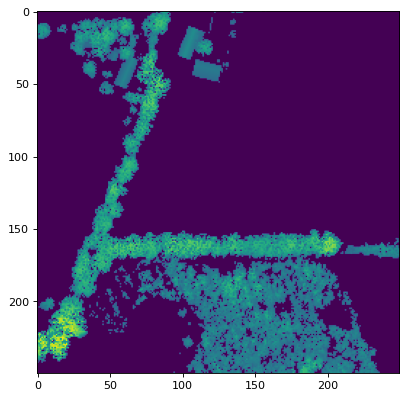

In [2]:
def tif_to_arr(fp:str):
    ds = gdal.Open(fp)
    gt = ds.GetGeoTransform()
    projec = ds.GetProjection()
    band = ds.GetRasterBand(1)
    return band.ReadAsArray()

# dsm_array = tif_to_arr("./DSM/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif")
# dtm_array = tif_to_arr("DTM/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif")
# diff_array = dsm_array - dtm_array
dsm_array = tif_to_arr("split/tile_1748.tif")
render_target = dsm_array

binmask = np.where((render_target >= np.mean(render_target)), render_target, 0)

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(binmask)

In [3]:
# diff_array.shape

## 3D Render

### Get the meshgrid with numpy

In [4]:
dem =  binmask

# This one is pretty ugly, I should find a way to open the file only once and get gt out of it
ds = gdal.Open("split/tile_1748.tif")
gt = ds.GetGeoTransform()

xres = gt[1]
yres = gt[5]

X = np.arange(gt[0], gt[0] + dem.shape[1]*xres, xres)
Y = np.arange(gt[3], gt[3] + dem.shape[0]*yres, yres)

X, Y = np.meshgrid(X, Y)

### Do the rendering with ipygany

In [5]:
# Create triangle indices
nx = binmask.shape[1]
ny = binmask.shape[0]

triangle_indices = np.empty((ny - 1, nx - 1, 2, 3), dtype=int)

r = np.arange(nx * ny).reshape(ny, nx)

triangle_indices[:, :, 0, 0] = r[:-1, :-1]
triangle_indices[:, :, 1, 0] = r[:-1, 1:]
triangle_indices[:, :, 0, 1] = r[:-1, 1:]

triangle_indices[:, :, 1, 1] = r[1:, 1:]
triangle_indices[:, :, :, 2] = r[1:, :-1, None]

triangle_indices.shape = (-1, 3)

# Create vertices
x = np.arange(-5, 5, 10/nx)
y = np.arange(-5, 5, 10/ny)

xx, yy = np.meshgrid(x, y, sparse=True)

vertices = np.empty((ny, nx, 3))
vertices[:, :, 0] = X
vertices[:, :, 1] = Y
vertices[:, :, 2] = dem
vertices = vertices.reshape(nx * ny, 3)

height_component = Component(name='value', array=dem)

mesh = PolyMesh(
    vertices=vertices,
    triangle_indices=triangle_indices,
    data={'height': [height_component]}
)

height_min = np.min(dem)
height_max = np.max(dem)

# Colorize by height
colored_mesh = IsoColor(mesh, input='height', min=height_min, max=height_max)

# Create a slider that will dynamically change the boundaries of the colormap
colormap_slider_range = FloatRangeSlider(value=[height_min, height_max], min=height_min, max=height_max, step=(height_max - height_min) / 100.)

jslink((colored_mesh, 'range'), (colormap_slider_range, 'value'))

# Create a colorbar widget
colorbar = ColorBar(colored_mesh)

# Colormap choice widget
colormap = Dropdown(
    options=colormaps,
    description='colormap:'
)

jslink((colored_mesh, 'colormap'), (colormap, 'index'))


AppLayout(
    left_sidebar=Scene([colored_mesh]),
    right_sidebar=VBox((colormap_slider_range, colormap, colorbar)),
    pane_widths=[2, 0, 1]
)

AppLayout(children=(Scene(children=[IsoColor(input='height', max=37.61000061035156, parent=PolyMesh(data=[Data…